# Compute Fairness Metrics Across Various User and Content Groups

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import gaussian_kde
import pandas as pd
import sys
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from data_utils import *
from model_utils import *

# Fairness on Dialect Proportion

### Augment Fairness Metrics with Model Predictions

In [4]:
DATA_FOLDER = "compiled_data"
FAIRNESS_FOLDER = "fairness_results"

# Input
DIALECT_METRIC_DATASET_PATH = f"{DATA_FOLDER}/dialect_metric_data.csv"
COMPILED_LABELED_TEST_DATASET_PATH = f"{DATA_FOLDER}/combined_labeled_data_test.csv" # Data the model has not seen

# Output
DIALECT_METRIC_PLUS_PREDICTIONS_DATASET_PATH = f"{FAIRNESS_FOLDER}/dialect_metric_plus_predictions.csv"

In [5]:
model = NLPHandler("BERT_limited.ckpt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Loading trained classifier BERT_limited.ckpt


INFO: lib level=1
INFO: root level=30
INFO: Detected pytorch backend for <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>.
INFO: Using backend Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.
DEBUG: Input dtype was not passed in. Defaulting to `torch.float32`.


In [6]:
# Load dialect dataset, and filter to only include tweets the model has not trained on
dialect_dataset = pd.read_csv(DIALECT_METRIC_DATASET_PATH)

model_unseen_dataset = pd.read_csv(COMPILED_LABELED_TEST_DATASET_PATH)
model_unseen_text = set(model_unseen_dataset["tweet_text"].values)

dialect_dataset = dialect_dataset[dialect_dataset["tweet_text"].isin(model_unseen_text)]

In [54]:
BATCH_SIZE = 32

FORCE_RECOMPUTE = False

if os.path.exists(DIALECT_METRIC_PLUS_PREDICTIONS_DATASET_PATH) and not FORCE_RECOMPUTE:
    dialect_plus_prediction_dataset = pd.read_csv(DIALECT_METRIC_PLUS_PREDICTIONS_DATASET_PATH)

else:
    prediction_fake_probabilities = []
    prediction_real_probabilities = []
    prediction_fake_logits = []
    prediction_real_logits = []

    for batch_start_ind in trange(0, len(dialect_dataset), BATCH_SIZE):
        batch = dialect_dataset["tweet_text"][batch_start_ind : batch_start_ind + BATCH_SIZE].tolist()
        batch_logits = model.classify(batch)
        batch_logit_normalizer = np.logaddexp(batch_logits[:, 0], batch_logits[:, 1])
        batch_fake_logits = batch_logits[:, 1] - batch_logit_normalizer # Normalized logits
        batch_real_logits = batch_logits[:, 0] - batch_logit_normalizer # Normalized logits
        batch_fake_probs = np.exp(batch_fake_logits)
        batch_real_probs = np.exp(batch_real_logits)
        
        prediction_fake_probabilities += batch_fake_probs.tolist()
        prediction_real_probabilities += batch_real_probs.tolist()
        prediction_fake_logits += batch_fake_logits.tolist()
        prediction_real_logits += batch_real_logits.tolist()
        
    dialect_plus_prediction_dataset = dialect_dataset.copy()
    dialect_plus_prediction_dataset["predicted_probability_fake"] = prediction_fake_probabilities
    dialect_plus_prediction_dataset["predicted_probability_real"] = prediction_real_probabilities
    dialect_plus_prediction_dataset["predicted_logit_fake"] = prediction_fake_logits
    dialect_plus_prediction_dataset["predicted_logit_real"] = prediction_real_logits

    dialect_plus_prediction_dataset.to_csv(DIALECT_METRIC_PLUS_PREDICTIONS_DATASET_PATH)
    
# Add rounded predicted label column
dialect_plus_prediction_dataset["predicted_label"] = dialect_plus_prediction_dataset["predicted_probability_fake"].round()

# Store dialect labels
dialect_column_names = [
    "african_american_dialect_proportion",
    "hispanic_dialect_proportion",
    "asian_dialect_proportion",
    "white_dialect_proportion"
]

print("Overall model accuracy:", (dialect_plus_prediction_dataset["predicted_probability_fake"].round() == dialect_plus_prediction_dataset["tweet_label"]).sum() / len(dialect_plus_prediction_dataset))

Overall model accuracy: 0.9618164967562558


### Discrete Fairness Measures

In [63]:
# Computes opportunity values (true positive or true negative rates) 
# for each given class mask over the dialect prediction dataset
def equal_opp(*class_masks, label=1):
    label_mask = dialect_plus_prediction_dataset["tweet_label"] == label
    prediction_correct = dialect_plus_prediction_dataset["predicted_probability_fake"].round() == label
    
    return [
        (class_mask & label_mask & prediction_correct).sum() / (class_mask & label_mask).sum()
        for class_mask in class_masks
    ]

def treatment_equality(*class_masks):
    return [(1 - equal_opp_fake) / (1 - equal_opp_real) for equal_opp_fake, equal_opp_real in zip(equal_opp(*class_masks, label=1), equal_opp(*class_masks, label=0))]

def predictive_parity(*class_masks):
    pred_mask = dialect_plus_prediction_dataset["predicted_probability_fake"].round() == 1
    label_mask = dialect_plus_prediction_dataset["tweet_label"] == 1
    
    return [
        (class_mask & pred_mask & label_mask).sum() / (class_mask & pred_mask).sum()
        for class_mask in class_masks
    ]
    
def disparate_impact(*class_masks):
    pred_mask = dialect_plus_prediction_dataset["predicted_probability_fake"].round() == 1
    
    return [
        (class_mask & pred_mask).sum() / (class_mask).sum()
        for class_mask in class_masks
    ]
    
def label_proportions(*class_masks):
    label_mask = dialect_plus_prediction_dataset["tweet_label"] == 1
    
    return [
        (class_mask & label_mask).sum() / (class_mask).sum()
        for class_mask in class_masks
    ]

In [64]:
dialect_columns = [dialect_plus_prediction_dataset[col] for col in dialect_column_names]

# Discrete classes = 1 std above mean for that dim
print(f"Means: {[col.mean() for col in dialect_columns]}")
print(f"Stds: {[col.std() for col in dialect_columns]}")
discrete_class_masks = [
    col >= col.mean() + col.std()
    for col in dialect_columns
]
for i in range(1, len(discrete_class_masks)):
    already_taken = discrete_class_masks[0].copy()
    for j in range(1, i):
        already_taken |= discrete_class_masks[j]
    discrete_class_masks[i] &= (~already_taken)

print("Dialect Proportions in Dataset:", [d.sum() / len(d) for d in discrete_class_masks])

Means: [0.12323694677031787, 0.19294588432847548, 0.08251278617237803, 0.6013043827288285]
Stds: [0.07863621044237379, 0.09024165562954646, 0.10947907346348433, 0.15552141748271697]
Dialect Proportions in Dataset: [0.14022242817423541, 0.11510658016682113, 0.10648748841519926, 0.1758109360518999]


In [65]:
print(f"FAKE Proportions: {label_proportions(*discrete_class_masks)}")
print(f"Disparate Impact: {disparate_impact(*discrete_class_masks)}")

FAKE Proportions: [0.25049570389953735, 0.2246376811594203, 0.5369886858137511, 0.3510806536636795]
Disparate Impact: [0.24256444150693984, 0.21739130434782608, 0.5387293298520452, 0.33842909857670006]


In [66]:
print("Accuracy for FAKE (Equal Opp) per class:", equal_opp(*discrete_class_masks, label=1))
print("Accuracy for REAL (Equal Opp) per class:", equal_opp(*discrete_class_masks, label=0))

Accuracy for FAKE (Equal Opp) per class: [0.9234828496042217, 0.9068100358422939, 0.9627228525121556, 0.9309309309309309]
Accuracy for REAL (Equal Opp) per class: [0.9850088183421517, 0.9823468328141225, 0.9530075187969925, 0.9821283509341998]


In [67]:
print("Accuracy for predicted FAKE (Predictive Parity) per class", predictive_parity(*discrete_class_masks))

Accuracy for predicted FAKE (Predictive Parity) per class [0.9536784741144414, 0.937037037037037, 0.9596122778675282, 0.9657320872274143]


### Continuous Fairness Measures

#### Correlation Coefficients

In [94]:
# Compute correlations between target column and dialect proportions for each dialect
# Optionally specify a ground-truth label to be conditioned on (equal opportunity)
def class_correlations(target_column_name="predicted_probability_fake", condition=None):
    if condition is None:
        data = dialect_plus_prediction_dataset
    else:
        data = dialect_plus_prediction_dataset[condition]
        
    matrix = data[[target_column_name, "african_american_dialect_proportion", "hispanic_dialect_proportion", "asian_dialect_proportion", "white_dialect_proportion"]].values
    correlations = np.corrcoef(matrix, rowvar=False)
    return correlations[0, 1:]

# Scatter plot for each class versus the target column
# Optionally specify a ground-truth label value to be conditioned on (equal opp)
def class_correlation_plot(target_column_name="predicted_probability_fake", label=None):
    if label is None:
        data = dialect_plus_prediction_dataset
    else:
        data = dialect_plus_prediction_dataset[dialect_plus_prediction_dataset["tweet_label"] == label]
    
    dialect_column_names = ["african_american_dialect_proportion", "hispanic_dialect_proportion", "asian_dialect_proportion", "white_dialect_proportion"]
    dialect_columns = [data[c].values for c in dialect_column_names]
    target_column = data[target_column_name].values
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    for i, dialect_name in enumerate(dialect_column_names):
        # Color by density
        xy = np.vstack([dialect_columns[i], target_column])
        density = gaussian_kde(xy)(xy)
        
        ax = axes[i // 2][i % 2]
        s_plot = ax.scatter(dialect_columns[i], target_column, c=density, s=10)
        ax.set_title(f"Given label {LABELS[label]}" if label is not None else "", fontsize=30)
        ax.set_xlabel(dialect_name.replace("_", " ").capitalize(), fontsize=30)
        ax.set_ylabel(target_column_name.replace("_", " ").capitalize(), fontsize=30)
        fig.colorbar(s_plot, ax=ax, label="Gaussian Kernel Density Estimate")
        
        # Best fit line
        ax.plot(np.unique(dialect_columns[i]), np.poly1d(np.polyfit(dialect_columns[i], target_column, 1))(np.unique(dialect_columns[i])), "b--")
        
    fig.tight_layout()
    plt.show()

In [95]:
print("Class -> Label correlations:\t\t\t\t\t", class_correlations("tweet_label"))
print()
print("Class -> Prob (Demographic Parity) correlations:\t\t", class_correlations("predicted_probability_fake"))
print("Class -> Prob | FAKE (Equal Opp) correlations:\t\t\t", class_correlations("predicted_probability_fake", dialect_plus_prediction_dataset["tweet_label"] == 1))
print("Class -> Prob | REAL (Equal Opp) correlations:\t\t\t", class_correlations("predicted_probability_fake", dialect_plus_prediction_dataset["tweet_label"] == 0))
print()
print("Class -> Pred (Demographic Parity) correlations:\t\t", class_correlations("predicted_label"))
print("Class -> Pred | FAKE (Equal Opp) correlations:\t\t\t", class_correlations("predicted_label", dialect_plus_prediction_dataset["tweet_label"] == 1))
print("Class -> Pred | REAL (Equal Opp) correlations:\t\t\t", class_correlations("predicted_label", dialect_plus_prediction_dataset["tweet_label"] == 0))
print()
print("Class -> FAKE | Pred (Predictive Parity) correlations:\t\t", class_correlations("tweet_label", dialect_plus_prediction_dataset["predicted_label"] == 1))

Class -> Label correlations:					 [-0.11344337 -0.18768251  0.14169688  0.0665162 ]

Class -> Prob (Demographic Parity) correlations:		 [-0.11015366 -0.18822262  0.15123955  0.05844868]
Class -> Prob | FAKE (Equal Opp) correlations:			 [-0.00096699 -0.03669472  0.04618241 -0.01854284]
Class -> Prob | REAL (Equal Opp) correlations:			 [-0.02251382 -0.04259991  0.06277466 -0.00244632]

Class -> Pred (Demographic Parity) correlations:		 [-0.1097738  -0.18644546  0.14990064  0.05816793]
Class -> Pred | FAKE (Equal Opp) correlations:			 [-0.00733079 -0.0349077   0.04150335 -0.01272437]
Class -> Pred | REAL (Equal Opp) correlations:			 [-0.01994923 -0.04008896  0.06116756 -0.00427892]

Class -> FAKE | Pred (Predictive Parity) correlations:		 [-0.02273176 -0.02865812 -0.01127043  0.03406567]


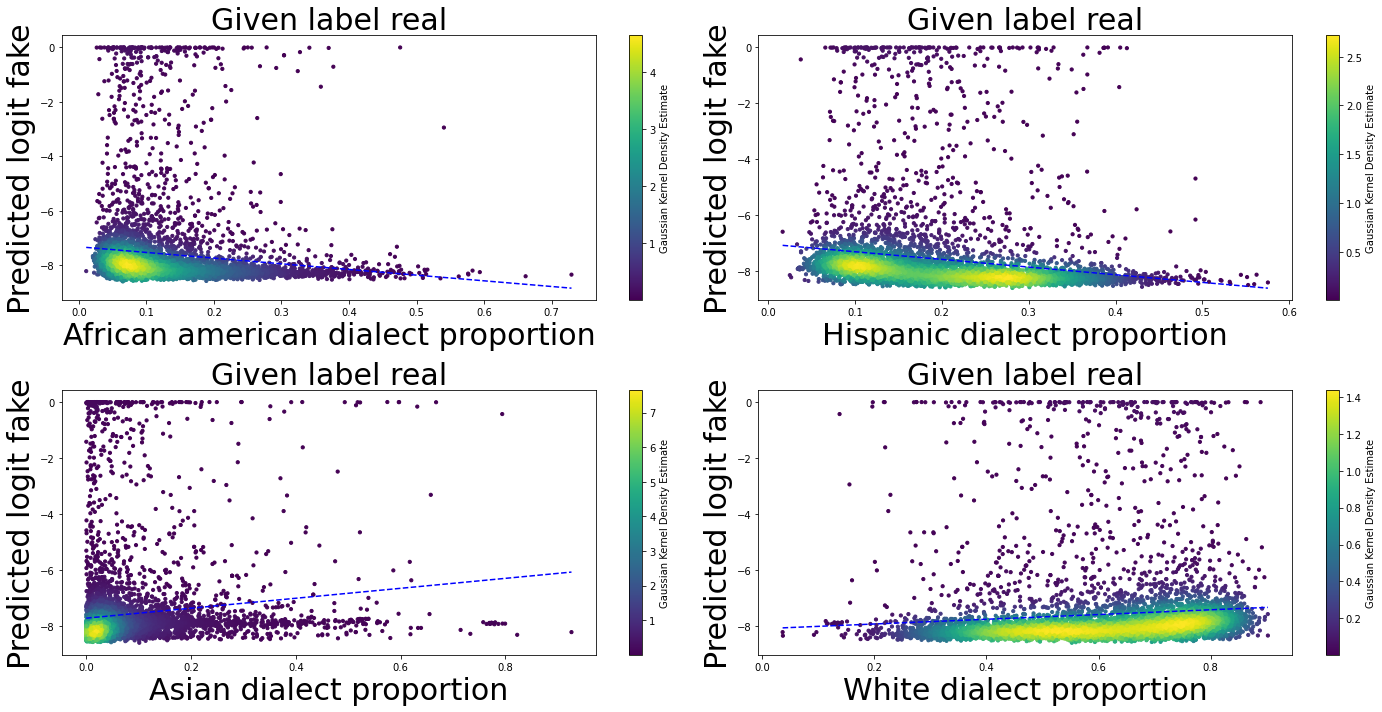

In [96]:
class_correlation_plot("predicted_logit_fake", label=0)

### Correlation to Max Correlation Combination of Dialects

In [68]:
from sklearn.cross_decomposition import CCA

dialect_matrix = dialect_plus_prediction_dataset[dialect_column_names].values
prediction_matrix = dialect_plus_prediction_dataset["predicted_label"].values
label_matrix = dialect_plus_prediction_dataset["tweet_label"].values

In [69]:
# Max correlation with predicted FAKE (Disparate Impact)

ca = CCA(n_components=1)
ca.fit(dialect_matrix, prediction_matrix)

axis = ca.x_rotations_[:, 0]

In [70]:
projected_dialects = np.dot(dialect_matrix, axis)
correlation = np.corrcoef(projected_dialects, prediction_matrix, rowvar=False)[0, 1]
print(f"Max Dialect -> Prediction Correlation: {correlation}")

Max Dialect -> Prediction Correlation: -0.20734455272563124


In [71]:
# Max correlation with predicted FAKE given FAKE (Equal Opp)

dialect_matrix_cond = dialect_matrix[label_matrix == 1]
prediction_matrix_cond = prediction_matrix[label_matrix == 1]

ca = CCA(n_components=1)
ca.fit(dialect_matrix_cond, predicted_prob_matrix_cond)
axis = ca.x_rotations_[:, 0]

In [72]:
projected_dialects = np.dot(dialect_matrix_cond, axis)
correlation = np.corrcoef(projected_dialects, prediction_matrix_cond, rowvar=False)[0, 1]
print(f"Max Dialect -> Prediction | FAKE: {correlation}")

Max Dialect -> Prediction | FAKE: -0.045661401509658625


In [77]:
# Max correlation with predicted TRUE given TRUE (Equal Opp)

dialect_matrix_cond = dialect_matrix[label_matrix == 0]
prediction_matrix_cond = 1 - prediction_matrix[label_matrix == 0]

ca = CCA(n_components=1)
ca.fit(dialect_matrix_cond, prediction_matrix_cond)
axis = ca.x_rotations_[:, 0]

In [78]:
projected_dialects = np.dot(dialect_matrix_cond, axis)
correlation = np.corrcoef(projected_dialects, prediction_matrix_cond, rowvar=False)[0, 1]
print(f"Max Dialect -> Predicted REAL | REAL: {correlation}")

Max Dialect -> Predicted REAL | REAL: -0.06341236838750111


In [75]:
# Max correlation with FAKE given predicted FAKE (Predictive Parity)

dialect_matrix_cond = dialect_matrix[prediction_matrix == 1]
label_matrix_cond = label_matrix[prediction_matrix == 1]

ca = CCA(n_components=1)
ca.fit(dialect_matrix_cond, label_matrix_cond)
axis = ca.x_rotations_[:, 0]

In [76]:
projected_dialects = np.dot(dialect_matrix_cond, axis)
correlation = np.corrcoef(projected_dialects, label_matrix_cond, rowvar=False)[0, 1]
print(f"Max Dialect -> FAKE | Predicted FAKE: {correlation}")

Max Dialect -> FAKE | Predicted FAKE: -0.03683997006502299


#### HGR Coefficients: Fairness-Aware Learning for Continuous Attributes and Treatments, J. Mary, C. Calauzènes, N. El Karoui, ICML 2019

In [46]:
sys.path.insert(0, "continuous-fairness")
from facl.independence.hgr import hgr, hgr_cond
from facl.independence.density_estimation.pytorch_kde import kde

In [47]:
# Compute the continuous HGR coefficient between each class and the target column,
# optionally conditioned on a label value
def class_hgr_correlation(target_column="predicted_probability_fake", condition=None):
    if condition is None:
        data = dialect_plus_prediction_dataset
    else:
        data = dialect_plus_prediction_dataset[condition]
    
    target = torch.from_numpy(data[target_column].values)
    classes = [
        torch.from_numpy(data[c].values)
        for c in ["african_american_dialect_proportion", "hispanic_dialect_proportion", "asian_dialect_proportion", "white_dialect_proportion"]
    ]
    
    return np.array([hgr(target, c, kde).item() for c in classes])

In [79]:
print("Class -> Prob (Dem Parity) HGR Correlations:\t\t\t", class_hgr_correlation("predicted_probability_fake"))
print("Class -> Prob | FAKE (Equal Opp) HGR Correlations:\t\t", class_hgr_correlation("predicted_probability_fake", dialect_plus_prediction_dataset["tweet_label"] == 1))
print("Class -> Prob | REAL (Equal Opp) HGR Correlations:\t\t", class_hgr_correlation("predicted_probability_fake", dialect_plus_prediction_dataset["tweet_label"] == 0))
print()
print("Class -> Prob (Dem Parity) HGR Correlations:\t\t\t", class_hgr_correlation("predicted_label"))
print("Class -> Prob | FAKE (Equal Opp) HGR Correlations:\t\t", class_hgr_correlation("predicted_label", dialect_plus_prediction_dataset["tweet_label"] == 1))
print("Class -> Prob | REAL (Equal Opp) HGR Correlations:\t\t", class_hgr_correlation("predicted_label", dialect_plus_prediction_dataset["tweet_label"] == 0))
print()
print("Class -> FAKE | Pred (Predictive Parity) HGR Correlations:\t", class_hgr_correlation("tweet_label", dialect_plus_prediction_dataset["predicted_probability_fake"].round() == 1))

Class -> Prob (Dem Parity) HGR Correlations:			 [0.13593644 0.25732466 0.20010742 0.14630007]
Class -> Prob | FAKE (Equal Opp) HGR Correlations:		 [0.03346178 0.0457915  0.08563971 0.03235621]
Class -> Prob | REAL (Equal Opp) HGR Correlations:		 [0.03499874 0.03928863 0.13451015 0.03582566]

Class -> Prob (Dem Parity) HGR Correlations:			 [0.13422526 0.25599274 0.19858563 0.14592755]
Class -> Prob | FAKE (Equal Opp) HGR Correlations:		 [0.00603858 0.00026777 0.13901004 0.00024162]
Class -> Prob | REAL (Equal Opp) HGR Correlations:		 [0.05025817 0.00059335 0.20518037 0.00046093]

Class -> FAKE | Pred (Predictive Parity) HGR Correlations:	 [0.00567705 0.00025504 0.13913461 0.0002333 ]
